# Astra target landing site example

## Derivation of Nozzle lift equation (fixed ascent rate)

An estimate of the bounds of Nozzle lift is required for scipy's differential evolution algorithm. We'll use a primitive approach, since the method calculates (integrates) the ascent rate equation anyway, and a penalty method will be used for ascent rates reaching outside the desired boundaries.

Force balance:

\begin{equation}
(m_{bal} + m_{pay} + m_{gas}) \frac{d^2z}{dt^2} = B - W - D = 0\\
B = W + D\\
V(\rho_{air} - \rho_{gas}) g = (m_{bal} + m_{pay})g + \frac{1}{2} \rho_{air} \left(\frac{dz}{dt}\right)^2 C_D A
\end{equation}

Then use balloon volume to get a 3rd order polynomial in terms of $r$

\begin{equation}
\frac{4}{3} \pi (\rho_{air} - \rho_{gas}) g r^3 - \frac{1}{2} \rho_{air} \left(\frac{dz}{dt}\right)^2 C_D \pi r^2 - (m_{bal} + m_{pay})g = 0
\end{equation}

Solve for r, and extract real positive root (should be unique: otherwise, raise an error). Then use the relation of gas mass (eqn 3 in "High-Altitude Gas Balloon Trajectory Prediction: A Monte Carlo Model") to obtain the nozzle lift:

\begin{equation}
m_{gas} = \rho^0_{gas} V^0 = \rho^0_{gas} \frac{L_N/g + m_{bal}}{\rho^0_{air} - \rho^0_{gas}}\\
L_N/g = \frac{4\pi}{3} r^3 (\rho_{air}-\rho_{gas}) - m_{bal} \hspace{1em} (kg)
\end{equation}

This is found in ```astra.flight_tools.nozzleLiftFixedAscent```, and has been validated with [habhub](http://habhub.org/calc/), which gives nozzle lift values of the same magnitude, and similar value (+- 10%)

## Ground distance equation

The Haversine formula is used to obtain ground distance $\Delta$ of the landing site from its target (assuming a spherical Earth), as

\begin{equation}
    \Delta = 2r\dot{}\mathrm{arcsin}\left( \sqrt{\mathrm{sin^2} \left( \frac{\phi_2 - \phi_1}{2}\right) + \mathrm{cos}(\phi_1) \mathrm{cos}(\phi_2) \mathrm{sin}^2 \left(\frac{\lambda_2 - \lambda_1}{2}\right)  }\right),
\end{equation}

where $\phi, \lambda$ refer to latitude and longitude respectively, and $r$ is the Earth's average radius ($=6371km$)

## 2D Optimization: Time + Nozzle Lift

In [1]:
%load_ext autoreload
%autoreload
import astra
from astra.target_landing import targetFlight
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.interpolate import interp1d
from astra.weather import forecastEnvironment
import astra
import os
%matplotlib notebook

In [2]:
targetLat = 51.077214
targetLon = -1.1866875398775423
targetElev = 137

# Use a previous forecast (allows offline development)
launch_datetime = datetime.today() + timedelta(days=1)
# simEnvironment = forecastEnvironment(launchSiteLat=50.903824,      # deg
#                                      launchSiteLon=-1.63697,     # deg
#                                      launchSiteElev=114.0,           # m
#                                      dateAndTime=launch_datetime,
#                                      forceNonHD=True,
#                                      debugging=True,
#                                      requestAll=False  # False has better memory overhead
#                                     )
# # Set up the example input data files (from 24/04/2017, Daytona Beach)
# fileDict = {}
# for paramName in GFS_Handler.weatherParameters.keys():
#     fileDict[paramName] = os.path.join(os.path.dirname(astra.__file__),
#         '../test/example_data',
#         'gfs_0p50_06z.ascii?{}[12:15][0:46][231:245][545:571]'.format(paramName))
# simEnvironment.loadFromNOAAFiles(fileDict)
# inputs = {'launchSiteForecasts': [simEnvironment]}

simulator = targetFlight(start_dateTime=launch_datetime,
                 targetLat=targetLat,
                 targetLon=targetLon,
                 targetElev=targetElev,
                 launchSites=[(50.903824, -1.63697, 114.0)],
                 balloonModel='TA100',
                 balloonGasType="Helium",
                 nozzleLift=1,
                 trainEquivSphereDiam=0.1,
                 inflationTemperature=0.0,
                 payloadTrainWeight=0.38,
                 windowDuration=72,
                 HD=False,
                 maxFlightTime=18000,
                 parachuteModel=None,
                 debugging=True,
                 log_to_file=False,
                 progress_to_file=False,
                 outputFile=os.path.join(''))

In [3]:
import copy

# Number of x-y points to use
Nx = 21
Ny = 21

bestProfile_bf, X, Y, distances = simulator.bruteForce()
results_bf = copy.deepcopy(simulator.results)

DEBUG:astra.weather:Fetched time zone data about the launch site: UTC offset is 1.000000 hours
DEBUG:astra.weather:Using UTC time 23/06/17 12:19
INFO:astra.weather:Preparing to download weather data for parameters:
DEBUG:astra.weather:    Launch site Latitude: 50.903824
DEBUG:astra.weather:    Launch site Longitude: -1.63697
DEBUG:astra.weather:    Launch time: 2017-06-23 12:19:20.555362
DEBUG:astra.GFS:Attempting to download cycle data.
DEBUG:astra.GFS:Requesting URL: http://nomads.ncep.noaa.gov:9090/dods/gfs_0p50/gfs20170622/gfs_0p50_12z.ascii?tmpprs[8:9][0:46][263:301][0:719]
DEBUG:astra.GFS:GFS cycle not found.
DEBUG:astra.GFS:Moving to next cycle
DEBUG:astra.GFS:Attempting to download cycle data.
DEBUG:astra.GFS:Requesting URL: http://nomads.ncep.noaa.gov:9090/dods/gfs_0p50/gfs20170622/gfs_0p50_06z.ascii?tmpprs[10:11][0:46][263:301][0:719]


DEBUG:astra.GFS:Requesting URL: http://nomads.ncep.noaa.gov:9090/dods/gfs_0p50/gfs20170622/gfs_0p50_06z.ascii?tmpprs[10:35][0:46][263:301][0:719]
DEBUG:astra.GFS:Temperature data downloaded


DEBUG:astra.GFS:Requesting URL: http://nomads.ncep.noaa.gov:9090/dods/gfs_0p50/gfs20170622/gfs_0p50_06z.ascii?hgtprs[10:35][0:46][263:301][0:719]
DEBUG:astra.GFS:Altitude data downloaded


DEBUG:astra.GFS:Requesting URL: http://nomads.ncep.noaa.gov:9090/dods/gfs_0p50/gfs20170622/gfs_0p50_06z.ascii?ugrdprs[10:35][0:46][263:301][0:719]
DEBUG:astra.GFS:U Winds data downloaded


DEBUG:astra.GFS:Requesting URL: http://nomads.ncep.noaa.gov:9090/dods/gfs_0p50/gfs20170622/gfs_0p50_06z.ascii?vgrdprs[10:35][0:46][263:301][0:719]
DEBUG:astra.GFS:V Winds data downloaded


Weather downloaded.


DEBUG:astra.GFS:Forecast successfully downloaded!
DEBUG:astra.weather:GFS data successfully downloaded.
INFO:astra.target_landing:Date range: [2017-06-23 13:19:20.555362, 2017-06-26 13:19:20.555362], Nx=19 points
INFO:astra.target_landing:Nozzle Lift range: [0.41604821396915026, 1.7128711861717523] (kg), Ny=21 points
DEBUG:astra.target_landing:Running brute force calculation
DEBUG:astra.target_landing:Running flight for datetime 2017-06-23 13:19:20.555362, nozzleLift=0.41604821396915026kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-23 13:19:20.555362, nozzleLift=0.4808893625792804kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-23 13:19:20.555362, nozzleLift=0.5457305111894104kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-23 13:19:20.555362, nozzleLift=0.6105716597995405kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-23 13:19:20.555362, nozzleLift=0.6754128084096707kg
DEBUG:astra.target_landing:Running flight for 

DEBUG:astra.target_landing:Running flight for datetime 2017-06-24 01:19:20.555362, nozzleLift=0.7402539570198008kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-24 01:19:20.555362, nozzleLift=0.8050951056299309kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-24 01:19:20.555362, nozzleLift=0.8699362542400609kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-24 01:19:20.555362, nozzleLift=0.9347774028501911kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-24 01:19:20.555362, nozzleLift=0.9996185514603212kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-24 01:19:20.555362, nozzleLift=1.0644597000704512kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-24 01:19:20.555362, nozzleLift=1.1293008486805813kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-24 01:19:20.555362, nozzleLift=1.1941419972907115kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-24 01:19:20.55536

DEBUG:astra.target_landing:Running flight for datetime 2017-06-24 13:19:20.555362, nozzleLift=1.3238242945109717kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-24 13:19:20.555362, nozzleLift=1.3886654431211016kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-24 13:19:20.555362, nozzleLift=1.453506591731232kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-24 13:19:20.555362, nozzleLift=1.5183477403413619kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-24 13:19:20.555362, nozzleLift=1.5831888889514922kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-24 13:19:20.555362, nozzleLift=1.6480300375616221kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-24 13:19:20.555362, nozzleLift=1.7128711861717523kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-24 17:19:20.555362, nozzleLift=0.41604821396915026kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-24 17:19:20.55536

DEBUG:astra.target_landing:Running flight for datetime 2017-06-25 05:19:20.555362, nozzleLift=0.5457305111894104kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-25 05:19:20.555362, nozzleLift=0.6105716597995405kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-25 05:19:20.555362, nozzleLift=0.6754128084096707kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-25 05:19:20.555362, nozzleLift=0.7402539570198008kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-25 05:19:20.555362, nozzleLift=0.8050951056299309kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-25 05:19:20.555362, nozzleLift=0.8699362542400609kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-25 05:19:20.555362, nozzleLift=0.9347774028501911kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-25 05:19:20.555362, nozzleLift=0.9996185514603212kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-25 05:19:20.55536

DEBUG:astra.target_landing:Running flight for datetime 2017-06-25 17:19:20.555362, nozzleLift=1.1293008486805813kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-25 17:19:20.555362, nozzleLift=1.1941419972907115kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-25 17:19:20.555362, nozzleLift=1.2589831459008416kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-25 17:19:20.555362, nozzleLift=1.3238242945109717kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-25 17:19:20.555362, nozzleLift=1.3886654431211016kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-25 17:19:20.555362, nozzleLift=1.453506591731232kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-25 17:19:20.555362, nozzleLift=1.5183477403413619kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-25 17:19:20.555362, nozzleLift=1.5831888889514922kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-25 17:19:20.555362

DEBUG:astra.target_landing:Running flight for datetime 2017-06-26 05:19:20.555362, nozzleLift=1.7128711861717523kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-26 09:19:20.555362, nozzleLift=0.41604821396915026kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-26 09:19:20.555362, nozzleLift=0.4808893625792804kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-26 09:19:20.555362, nozzleLift=0.5457305111894104kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-26 09:19:20.555362, nozzleLift=0.6105716597995405kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-26 09:19:20.555362, nozzleLift=0.6754128084096707kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-26 09:19:20.555362, nozzleLift=0.7402539570198008kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-26 09:19:20.555362, nozzleLift=0.8050951056299309kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-26 09:19:20.5553

<IPython.core.display.Javascript object>


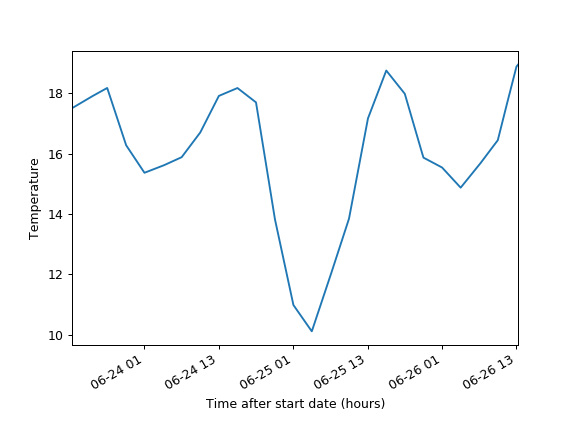

In [14]:
# Check that the weather interpolators work over this range (not a constant)
import matplotlib.dates as mdates
simEnvironment = simulator.environment

# Plot weather as a function of time over the date range:
ts = np.linspace(0, simEnvironment.forecastDuration, 3001)
datetimes = [simEnvironment.dateAndTime + timedelta(hours=t) for t in ts]

Ps = [simEnvironment.getTemperature(simEnvironment.launchSiteLat,
                                        simEnvironment.launchSiteLon,
                                        simEnvironment.launchSiteElev, dt)
          for dt in datetimes]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(datetimes, Ps)
ax.set_ylabel("Temperature")
ax.set_xlabel("Time after start date (hours)")

xtick_locator = mdates.AutoDateLocator()
xtick_formatter = mdates.AutoDateFormatter(xtick_locator)
ax.xaxis.set_major_locator(xtick_locator)
ax.xaxis.set_major_formatter(xtick_formatter)
ax.set_xlim(datetimes[0], datetimes[-1])

fig.autofmt_xdate()


In [ ]:
# Visualise the best result paths
simulator.plotPaths3D()

[ 0  4  8 12 16 20 24 28 32 36 40 44 48 52 56 60 64 68 72 76]


<IPython.core.display.Javascript object>


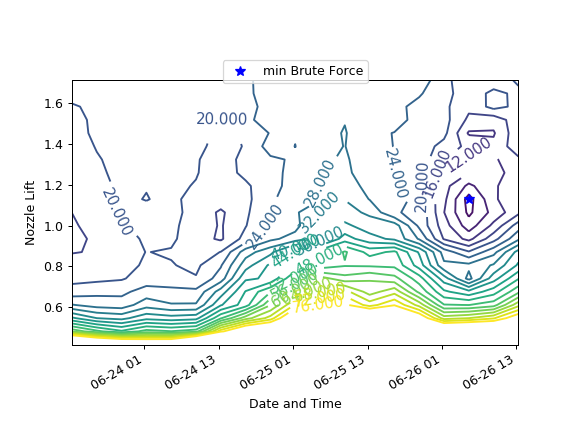

/home/pchambers/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:370: RuntimeWarning: invalid value encountered in true_divide
  dist = np.add.reduce(([(abs(s)[i] / L[i]) for i in range(xsize)]), -1)


In [26]:
%autoreload
import astra

# fig2, ax2 = simulator.plotLandingSites()
simulator.results = results_bf
simulator.bestProfile = bestProfile_bf

levels = np.arange(0, 80, 4)
print(levels)
fig3, ax3 = simulator.plotLandingSiteDistanceContours(X, Y, distances.T, appendLabel=' Brute Force', levels=levels)


## Nelder Mead Simplex Algorithm

In [ ]:
%autoreload
import astra

In [ ]:
# Optimize with Scipy:
res_scipy = simulator.optimizeTargetLandingSite(x0=[0.5*simulator.windowDuration, 1.0], options={"disp": True})
bestProfile_scipy = simulator.bestProfile
results_scipy = simulator.results
Xs_scipy = simulator.Xs

In [ ]:
# Optimize with scipy differential evolution
simulator.bestProfile = bestProfile_scipy
simulator.results = results_scipy
simulator.Xs = Xs_scipy
simulator.plotLandingSiteDistances(fig3, ax3, marker='rx', bestMarker='r*', appendLabel=' Nelder-Mead')

In [ ]:
print(res_scipy)

## L-BFGS-B Algorithm

In [ ]:
from astra.flight_tools import nozzleLiftFixedAscent

# Optimize with Scipy:
start_timedelta = 0
end_timedelta = simulator.windowDuration

nozzleLiftLowerBound = nozzleLiftFixedAscent(simulator.minAscentRate,
                simulator._balloonWeight, simulator.payloadTrainWeight,
                simulator.environment.inflationTemperature,
                simulator.environment.getPressure(simulator.launchSiteLat,
                                                  simulator.launchSiteLon,
                                                  simulator.launchSiteElev,
                                                  simulator.start_dateTime),
                simulator._gasMolecularMass, simulator.excessPressureCoeff,
                CD=(0.225 + 0.425)/2.)
nozzleLiftUpperBound = nozzleLiftFixedAscent(simulator.maxAscentRate,
                simulator._balloonWeight, simulator.payloadTrainWeight,
                simulator.environment.inflationTemperature,
                simulator.environment.getPressure(simulator.launchSiteLat,
                                                  simulator.launchSiteLon,
                                                  simulator.launchSiteElev,
                                                  simulator.start_dateTime),
                simulator._gasMolecularMass, simulator.excessPressureCoeff,
                CD=(0.225 + 0.425)/2.)

res_lbfgsb = simulator.optimizeTargetLandingSite(x0=[0.5*simulator.windowDuration, 1.0],
                                                 method='L-BFGS-B',
                                                 bounds=([start_timedelta, end_timedelta],
                                                         [nozzleLiftLowerBound, nozzleLiftUpperBound]),
                                                 options={"disp": True, "maxfun":200},
                                                 )
bestProfile_lbfgsb = simulator.bestProfile
results_lbfgsb = simulator.results
Xs_lbfgsb = simulator.Xs

In [ ]:
# Optimize with scipy differential evolution
simulator.bestProfile = bestProfile_lbfgsb
simulator.results = results_lbfgsb
simulator.Xs = Xs_lbfgsb
simulator.plotLandingSiteDistances(fig3, ax3, marker='cx', bestMarker='c*', appendLabel=' L-BFGS-B')

In [ ]:
print(res_lbfgsb)

## Scipy differential Evolution

In [ ]:
%autoreload
import astra

res_de = simulator.optimizeTargetLandingSite(method='DE', tol=1, maxiter=6)
results_de = simulator.results
bestProfile_de = simulator.bestProfile
Xs_de = simulator.Xs

In [ ]:
res_de

In [ ]:
simulator.results = results_de
simulator.bestProfile = bestProfile_de
simulator.Xs = Xs_de
simulator.plotLandingSiteDistances(fig3, ax3, marker='kx', bestMarker='k*', appendLabel=' DE')

In [ ]:
fig3.savefig('Distance2D_NozzleLift_LaunchTime.pdf')

In [ ]:
Nx = simulator.windowDuration / 4 + 1
Ny = 21
print("Brute Force: delta={}, nevals={}".format(bestProfile_bf.distanceFromTarget, Nx * Ny))
print("Differential Evolution: delta={}, nevals={}".format(bestProfile_de.distanceFromTarget), res_de.nfev)
print("Nelder Mead: {}, nevals={}".format(bestProfile_scipy.distanceFromTarget, res_scipy.nfev))